---
author: Zeel B Patel
badges: true
categories: ML, GP
description: A trial
title: Can Rank 1 GPs represent all GPs?
date: '2023-07-31'
toc: true
---

In [64]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.distributions as dist
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from gpytorch.kernels import RBFKernel, Kernel

In [65]:
class Rank1Kernel(nn.Module):
    def __init__(self, input_dim, output_dim, n_neurons_per_layer, activation):
        super().__init__()
        self.init = nn.Linear(input_dim, n_neurons_per_layer[0])
        self.n_neurons_per_layer = n_neurons_per_layer
        self.activation = activation
        
        for i in range(1, len(n_neurons_per_layer)):
            setattr(self, f'fc{i}', nn.Linear(n_neurons_per_layer[i-1], n_neurons_per_layer[i]))
        
        self.out = nn.Linear(n_neurons_per_layer[-1], output_dim)
        
    def forward(self, x1, x2):
        def _forward(x):
            x = self.init(x)
            for i in range(1, len(self.n_neurons_per_layer)):
                x = getattr(self, f'fc{i}')(x)
                x = self.activation(x)
            return self.out(x)
        
        x1 = _forward(x1)
        x2 = _forward(x2)
        
        # print(x1.shape, x2.shape)
        covar = x1 @ x2.T
        # print(covar.shape, gt_covar.shape, x1.shape, x2.shape)
        return covar

In [66]:
fixed_kernel = RBFKernel()
fixed_kernel.lengthscale = 0.3

X1 = torch.linspace(-1, 1, 100).view(-1, 1)

In [67]:
epochs = 1000
n_neurons_per_layer = [64]*4
output_dim = 10
kernel = Rank1Kernel(1, output_dim, n_neurons_per_layer, torch.sin)
optimizer = torch.optim.Adam(kernel.parameters(), lr=0.001)

losses = []
with torch.no_grad():
    gt_covar = fixed_kernel(X1, X1).evaluate_kernel().tensor
    
bar = tqdm(range(epochs))
for epoch in bar:
    optimizer.zero_grad()
    pred_covar = kernel(X1, X1)
    loss = torch.mean((gt_covar - pred_covar)**2)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    bar.set_description(f"Loss: {loss.item():.4f}")

Loss: 0.0001: 100%|██████████| 1000/1000 [00:06<00:00, 150.34it/s]


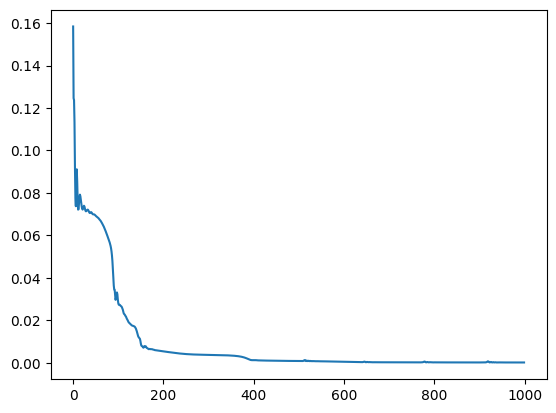

In [68]:
plt.plot(losses);

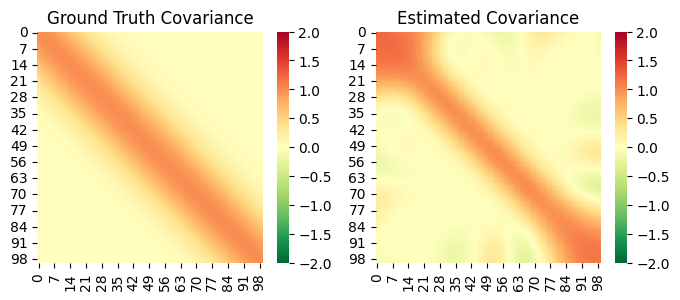

In [69]:
fig, ax = plt.subplots(1,2,figsize=(8, 3))

sns.heatmap(gt_covar, ax=ax[0], cmap='RdYlGn_r', cbar=True, vmin=-2, vmax=2)
ax[0].set_title('Ground Truth Covariance')

X_new = torch.linspace(-1.5, 1.5, 100).view(-1, 1)
with torch.no_grad():
    est_covar = kernel(X_new, X_new)
sns.heatmap(est_covar, ax=ax[1], cmap='RdYlGn_r', cbar=True, vmin=-2, vmax=2)
ax[1].set_title('Estimated Covariance');

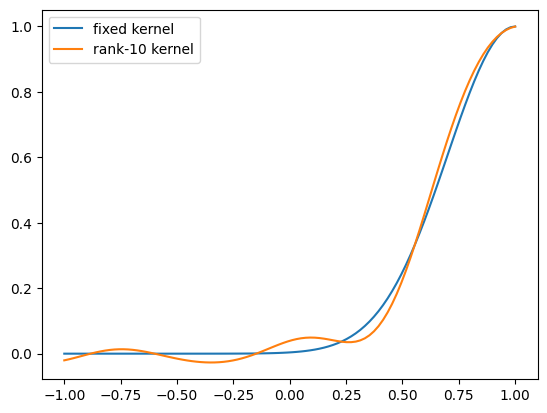

In [70]:
# plt.plot()

X2 = torch.zeros(1, 1) + 1
with torch.no_grad():
    variance = gt_covar[-1, :]
    plt.plot(X1, variance.numpy(), label="fixed kernel");
    
    variance = kernel(X1, X2)
    plt.plot(X1, variance.numpy(), label=f"rank-{output_dim} kernel");
    
    plt.legend()

torch.Size([100, 100])


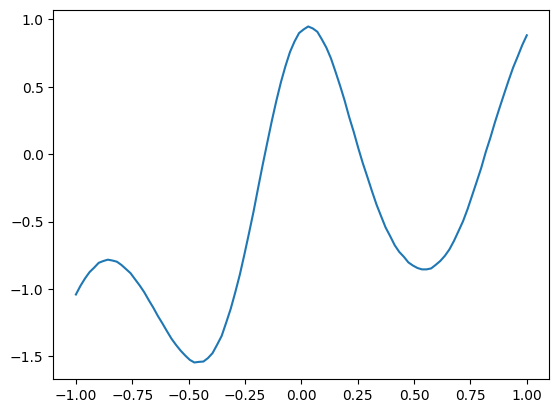

In [102]:
print(gt_covar.shape)
torch.random.manual_seed(2)
norm = dist.MultivariateNormal(torch.zeros(100), gt_covar + 1e-5 * torch.eye(100))
y = norm.sample()
plt.plot(X1, y);

0: 0.5698477029800415
1: 0.006691396702080965
2: 0.0001796285796444863
3: 0.00022799619182478637
4: 0.0008216467685997486
5: 0.00304242386482656


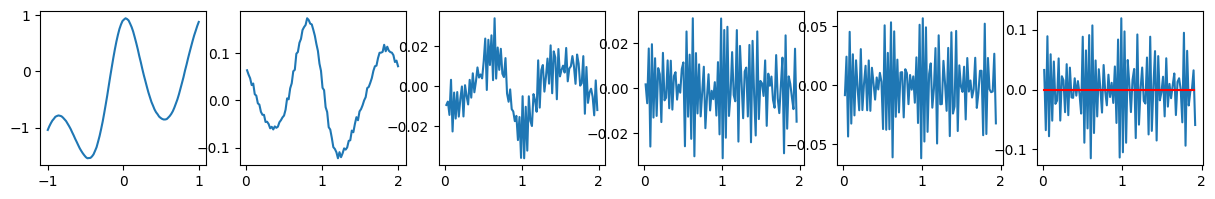

In [116]:
n = 6

fig, ax = plt.subplots(1, n, figsize=(15, 2))
d_x = X1
d_y = y
for i in range(n):
    print(f"{i}: {torch.var(d_y)}")
    ax[i].plot(d_x, d_y)
    d_x = d_x[1:] - d_x[:-1]
    d_x = torch.cumsum(d_x, dim=0)
    d_y = d_y[1:] - d_y[:-1]
    
f = lambda x: torch.zeros_like(x)
ax[-1].plot(d_x, f(d_x), c="r", label="f(x)")